In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from itertools import product
from utils import tMCL
from scipy.stats import norm
from utils import kl_eigenfunctions, generate_quantization_points, reconstruct_quantized_trajectories,generate_brownian_motion,plot_brownian_trajectories,plot_brownian_bridge_samples,generate_brownian_bridge_samples

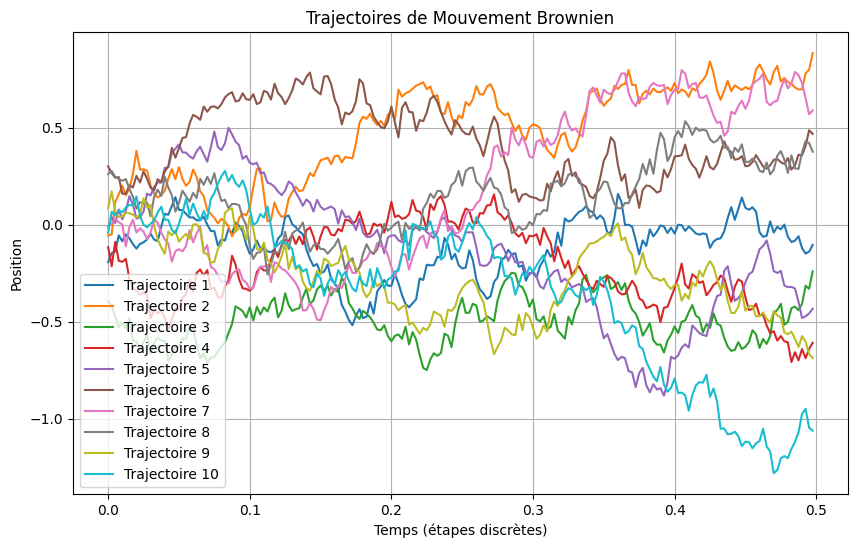

In [4]:
 #Exemple d'utilisation
batch_size = 10
nb_step_simulation = 200
nb_timesteps_discretisation = 400
fixed_start_point = None #(0.2, 20)

trajectories = generate_brownian_motion(batch_size, nb_step_simulation, nb_timesteps_discretisation, fixed_start_point)
plot_brownian_trajectories(trajectories, nb_step_simulation,nb_timesteps_discretisation)


In [8]:
# import torch
# import torch.nn as nn

# class tMCL(nn.Module):
#     def __init__(
#         self, 
#         cond_dim,       # dimension d'entrée (== 1, le point initial)
#         nb_step_simulation,  # longueur des trajectoires générées
#         n_hypotheses, 
#         device,  
#         loss_type = "relaxted_wta" 
#     ):
#         super().__init__()
       
#         self.loss_type = loss_type
#         self.nb_step_simulation = nb_step_simulation
#         self.n_hypotheses = n_hypotheses

#         self.backbone = nn.Sequential(
#                 nn.Linear(cond_dim, 50),
#                 nn.ReLU(),
#                 nn.Linear(50, 50)).to(device) #the backbone 
        
#         self.prediction_heads = nn.ModuleList([
#             nn.Sequential(
#                 nn.Linear(50, nb_step_simulation)
#             ).to(device)
#             for _ in range(n_hypotheses)
#         ])
       
       
#     def forward(self, distr_args):
       
#         # (A) Passer dans la backbone => [B, hidden_dim]
#         features = self.backbone(distr_args)
#         pred_list = []
#         for head in self.prediction_heads:
#             out = head(features)  # => [B, nb_step_simulation]
#             pred_list.append(out)
#         prediction_list = torch.stack(pred_list, dim=1)  # => [B, K, nb_step_simulation]
#         return prediction_list




#     def log_prob(self, target, distr_args):
#         target = target.squeeze(-1)  # [B, nb_step_simulation]
#         prediction_list = self.forward(distr_args)  # [B, K, nb_step_simulation]
#         pairwise_mse = torch.sum((prediction_list - target.unsqueeze(1))**2, dim=-1)  # [B, K]

#         if self.loss_type == "relaxted_wta":
#             epsilon = 0.05
#             n_hypotheses = pairwise_mse.shape[1]
#             winner, _ = pairwise_mse.min(dim=1)
#             mcl_loss = (1 - epsilon * n_hypotheses / (n_hypotheses - 1)) * winner + \
#                        (epsilon / (n_hypotheses - 1)) * pairwise_mse.sum(dim=1)
#             mcl_loss_mean = mcl_loss.mean()
            
#         else:
            
        
#             mcl_loss, _ = pairwise_mse.min(dim=1)
        
#             mcl_loss_mean = mcl_loss.mean()

       
#         return mcl_loss_mean

In [7]:

def train_tMCL(
    model, 
    num_epochs, 
    batch_size, 
    nb_step_simulation, 
    nb_timesteps_discretisation, 
    device, 
    learning_rate=0.001, 
    fixed_start_point=None
):
    """
    Entraîne le réseau de neurones tMCL avec des trajectoires browniennes.

    :param model: Instance du modèle tMCL
    :param num_epochs: Nombre d'époques d'entraînement
    :param batch_size: Taille du batch pour la génération de trajectoires
    :param nb_step_simulation: Longueur des trajectoires simulées
    :param nb_timesteps_discretisation: Nombre total de points de discrétisation sur [0, 1]
    :param device: Dispositif d'exécution (CPU ou GPU)
    :param learning_rate: Taux d'apprentissage
    :param fixed_start_point: Point de départ fixe pour les trajectoires (ou None pour aléatoire)
    :return: Modèle entraîné
    """
    # Définir l'optimiseur et la fonction de perte
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Basculer le modèle en mode entraînement
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        # Générer un batch de trajectoires browniennes
        trajectories = generate_brownian_motion(
            batch_size, nb_step_simulation, nb_timesteps_discretisation, fixed_start_point
        ).to(device)

        # Les points de départ : distr_args (extraire x0 des trajectoires)
        distr_args = trajectories[:, 0, :]#.squeeze(-1)  # [batch_size, 1]

        # Cibles : target_list (les trajectoires complètes)
        target_list = trajectories[:, :, :]

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Calculer les prédictions et la perte
        loss = model.log_prob(target_list, distr_args)

        # Rétropropagation
        loss.backward()

        # Mettre à jour les poids
        optimizer.step()

        # Afficher les progrès
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    return model


batch_size = 10000 #2000 was good
nb_step_simulation = 100
nb_timesteps_discretisation = 300
fixed_start_point =None # (0.2, 0)  # Exemple : (0.2, 20) ou None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Définir les hyperparamètres du modèle
model = tMCL(
    cond_dim=1, 
    nb_step_simulation=nb_step_simulation,
    n_hypotheses=10,
    device=device,
    loss_type = "relaxted_wta" #relaxted_wta
)

# Lancer l'entraînement
trained_model = train_tMCL(
    model=model,
    num_epochs=250,
    batch_size=batch_size,
    nb_step_simulation=nb_step_simulation,
    nb_timesteps_discretisation=nb_timesteps_discretisation,
    device=device,
    learning_rate=0.001,
    fixed_start_point=fixed_start_point)

Epoch [10/250], Loss: 12.1013
Epoch [20/250], Loss: 6.8882
Epoch [30/250], Loss: 5.7377
Epoch [40/250], Loss: 5.0368
Epoch [50/250], Loss: 4.7446
Epoch [60/250], Loss: 4.6874
Epoch [70/250], Loss: 4.6530
Epoch [80/250], Loss: 4.6998
Epoch [90/250], Loss: 4.6180
Epoch [100/250], Loss: 4.5865
Epoch [110/250], Loss: 4.5839
Epoch [120/250], Loss: 4.6217
Epoch [130/250], Loss: 4.6247
Epoch [140/250], Loss: 4.6184
Epoch [150/250], Loss: 4.6100
Epoch [160/250], Loss: 4.6130
Epoch [170/250], Loss: 4.5505
Epoch [180/250], Loss: 4.6223
Epoch [190/250], Loss: 4.6414
Epoch [200/250], Loss: 4.6150
Epoch [210/250], Loss: 4.6530
Epoch [220/250], Loss: 4.6298
Epoch [230/250], Loss: 4.6131
Epoch [240/250], Loss: 4.6583
Epoch [250/250], Loss: 4.6109


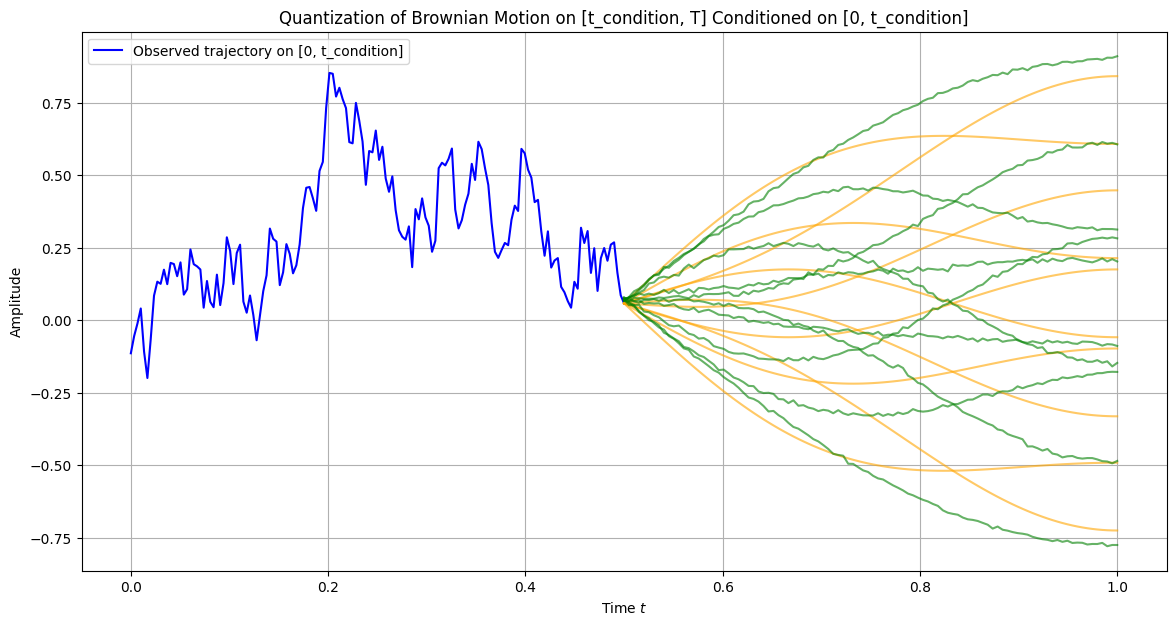

In [13]:
T = 1.0             # Intervalle de temps [0, T]
t_condition = 0.5   # Point où la trajectoire est connue
prediction_length = nb_step_simulation/ nb_timesteps_discretisation  #correspond to the prediciton length
num_steps = nb_timesteps_discretisation     # Nombre de points dans l'intervalle total
m = 2               # Nombre de dimensions utilisées (troncature)
N_levels = [5, 2]   # Niveaux de quantification pour chaque dimension

# Discrétisation de l'intervalle de temps
t_full = np.linspace(0, T, num_steps)
t_prediction = np.linspace(0, prediction_length, int(prediction_length * num_steps / T))
t_adjusted = np.linspace(t_condition, T, len(t_prediction))

# Calculer les fonctions propres et valeurs propres pour le mouvement brownien
eigenfunctions, eigenvalues = kl_eigenfunctions(t_prediction, prediction_length, m)

# Simuler une trajectoire Brownienne sur [0, t_condition]
#np.random.seed(42)
t_observed = np.linspace(0, t_condition, int(t_condition * num_steps / T))
trajectory_0_t = np.cumsum(np.sqrt(1 / len(t_observed)) * np.random.randn(len(t_observed)))

# Dernière valeur observée pour conditionner la quantification
B_t = trajectory_0_t[-1]

# Reconstruire les trajectoires quantifiées pour [0, prediction_length]
trajectories_quantized = reconstruct_quantized_trajectories(N_levels, eigenfunctions, eigenvalues) #nb hyp*timesteps
#here : adding the neural prediction and after good for plotting. 
predictions = trained_model.forward(torch.tensor([[float(B_t)]])) 
predictions_neural = predictions[0].detach().numpy()

# Ajouter B_t pour repositionner les trajectoires sur [t_condition, T]
trajectories_conditioned = trajectories_quantized + B_t

# Visualisation
plt.figure(figsize=(14, 7))

# Trajectoire observée sur [0, t_condition]
plt.plot(t_observed, trajectory_0_t, label="Observed trajectory on [0, t_condition]", color='blue')

# Trajectoires quantifiées sur [t_condition, T]
for trajectory in trajectories_conditioned:
    plt.plot(t_adjusted, trajectory, alpha=0.6, color='orange')

i=0
for trajectory in predictions_neural:
    i+=1
    # if i == 2:
    #     continue 
    plt.plot(t_adjusted, trajectory, alpha=0.6, color='green')
    

plt.title("Quantization of Brownian Motion on [t_condition, T] Conditioned on [0, t_condition]")
plt.xlabel("Time $t$")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

In [22]:
trajectories_conditioned.shape

(10, 200)

Optionnal, but not necessary (the following)

ValueError: x and y must have same first dimension, but have shapes (200,) and (100,)

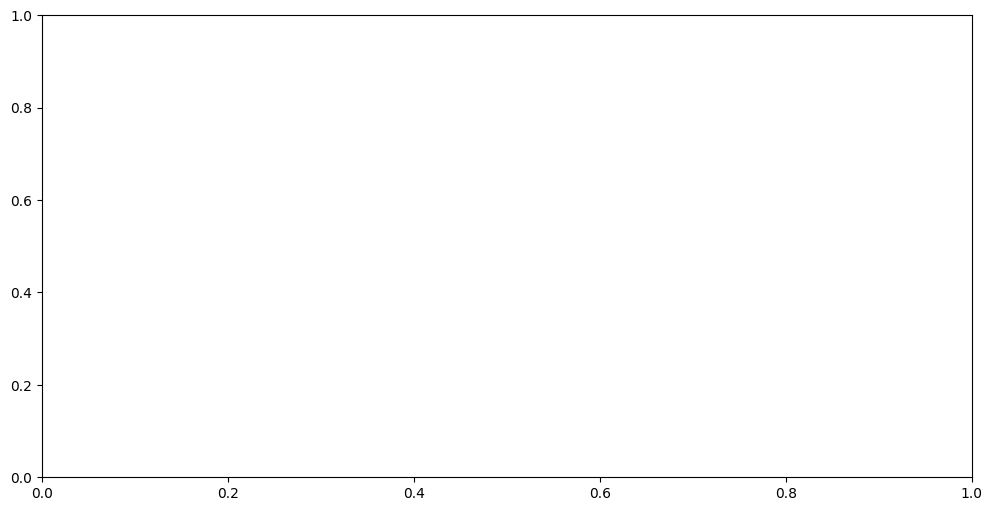

In [17]:
def plot_predictions(predictions, x0, nb_step_simulation):
    """
    Trace les trajectoires prédites par le modèle à partir des points initiaux x0.
    
    :param predictions: Tenseur de dimension [batch_size, K, nb_step_simulation] (prédictions du modèle)
    :param x0: Points initiaux x0, tensor [batch_size, 1]
    :param nb_step_simulation: Nombre d'étapes de simulation
    """
    batch_size, num_hypotheses, _ = predictions.shape
    
    # Configuration des axes
    time = torch.linspace(0, 1, nb_step_simulation).cpu().numpy()  # Discrétisation sur [0, 1]

    plt.figure(figsize=(12, 6))
    
    for i in range(batch_size):
        plt.subplot(1, batch_size, i + 1)
        
        # Tracer toutes les hypothèses pour un exemple
        for k in range(num_hypotheses):
            plt.plot(time, predictions[i, k].detach().cpu().numpy(), label=f'Hypothesis {k + 1}')
        
        plt.title(f'Trajectories for x0={x0[i].item():.2f}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

predictions = trained_model.forward(torch.tensor([[ -1.4]]))  # Utiliser x0 comme entrée
plot_predictions(predictions, torch.tensor([[ -1.4]]), nb_step_simulation)


/Users/adriencortes/.venvs/research_time_series/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


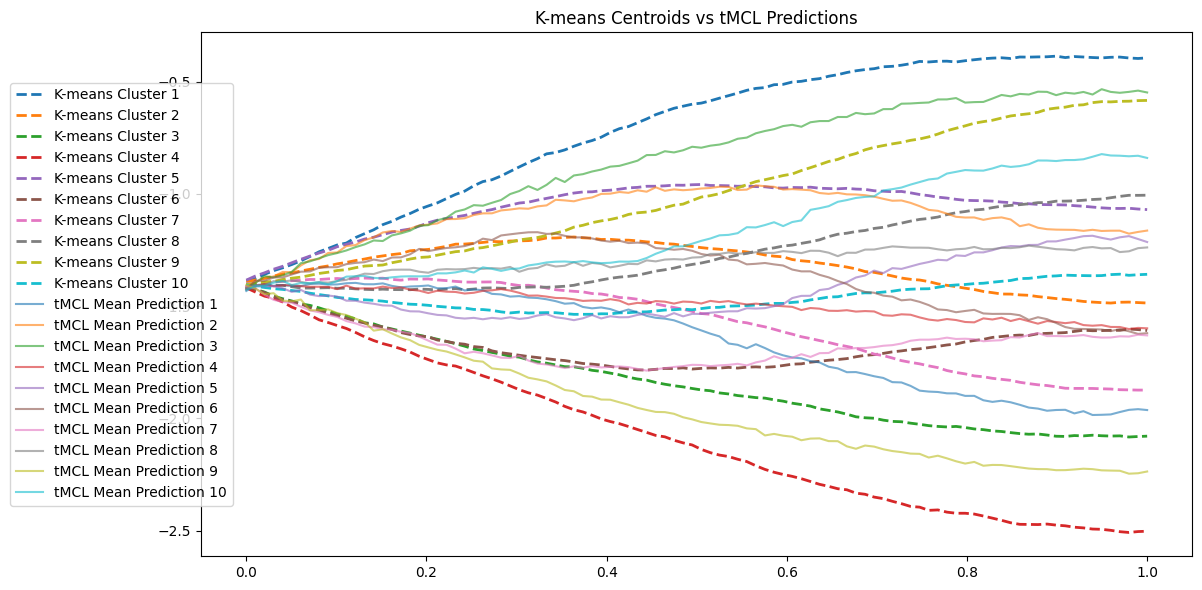

/var/folders/jb/8bmzmwqn3h14s2z9jr4gfg880000gn/T/ipykernel_33151/1138497519.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


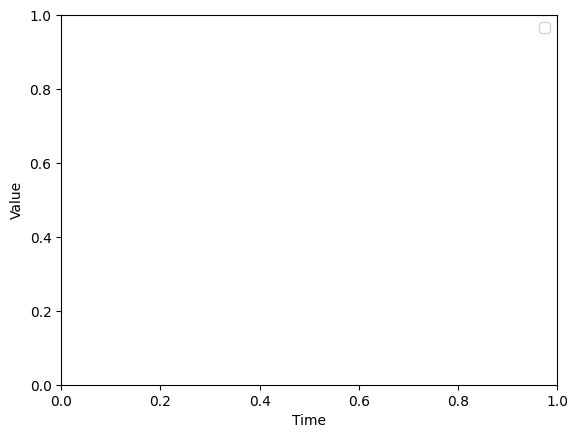

In [20]:
def plot_kmeans_centers_vs_tMCL(kmeans_centroids, tMCL_predictions, nb_step_simulation):
    """
    Trace les centres de clusters K-means et les trajectoires moyennes prédites par tMCL.
    
    :param kmeans_centroids: Centroides des clusters K-means [n_clusters, nb_step_simulation]
    :param tMCL_predictions: Trajectoires prédites par tMCL [batch_size, K, nb_step_simulation]
    :param nb_step_simulation: Nombre d'étapes de simulation
    """
    n_clusters = kmeans_centroids.shape[0]
    time = torch.linspace(0, 1, nb_step_simulation).cpu().numpy()

    # Moyenne des prédictions de tMCL sur les hypothèses
    tMCL_mean_predictions = tMCL_predictions.detach().cpu().numpy()  # [batch_size, nb_step_simulation]

    plt.figure(figsize=(12, 6))

    # Tracer les centroides de K-means
    for i, centroid in enumerate(kmeans_centroids):
        plt.plot(time, centroid, label=f'K-means Cluster {i + 1}', linestyle='--', linewidth=2)

    # Tracer les prédictions moyennes de tMCL
    for i in range(tMCL_mean_predictions.shape[0]):
        #if i ==6:
            # continue
        plt.plot(time, tMCL_mean_predictions[i], label=f'tMCL Mean Prediction {i + 1}', alpha=0.6)

    plt.title('K-means Centroids vs tMCL Predictions')
    # Positionner la légende à gauche
    plt.legend(loc='center left', bbox_to_anchor=(-0.2, 0.5), borderaxespad=0.5)
    
    plt.tight_layout()
    plt.show()
    
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


# Exemple d'utilisation
batch_size = 5000
nb_step_simulation = 100
nb_timesteps_discretisation = 300

nb_hypotheses = 10  # Doit correspondre au modèle
fixed_start_point = (0.2, -1.4)

# Générer les trajectoires browniennes
trajectories = generate_brownian_motion(
    batch_size, nb_step_simulation, nb_timesteps_discretisation, fixed_start_point=fixed_start_point
).to(device)

x0 = trajectories[:, 0, :].squeeze(-1)  # Points initiaux [batch_size]

# Appliquer K-means sur les trajectoires
trajectories_flat = trajectories[:, :, 0].cpu().numpy()  # [batch_size, nb_step_simulation]
kmeans = KMeans(n_clusters=nb_hypotheses, random_state=42)
kmeans_labels = kmeans.fit_predict(trajectories_flat)

# Obtenir les centroides de K-means
kmeans_centroids = kmeans.cluster_centers_  # [n_clusters, nb_step_simulation]

# Obtenir les prédictions de tMCL
tMCL_predictions  = trained_model.forward(torch.tensor([[ -1.4]]))[0]  # [batch_size, K, nb_step_simulation]

# Tracer les résultats
plot_kmeans_centers_vs_tMCL(kmeans_centroids, tMCL_predictions, nb_step_simulation)